<a href="https://colab.research.google.com/github/Passssa/Labs-of-Machine-Learning/blob/main/Lab4/Lab4_var16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   

In [2]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


In [4]:
!pip install watermark
%load_ext watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 


# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бэггинга   
* как вырастить случайный лес  
* как настроить модель бустинга на деревьях решений  
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, бэггинг, случайный лес, бустинг, дерево регрессии  
*Данные*: `in-vehicle-coupon-recommendation.csv`. Источник: [сайт Калифорнийского университета в Ирвине](https://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation)

In [7]:
# выводим информацию о версиях python и пакетов
%watermark -a "your_name" -d -v -p numpy,pandas,matplotlib,sklearn 

Author: your_name

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

numpy     : 1.21.6
pandas    : 1.3.5
matplotlib: 3.2.2
sklearn   : 1.0.2



# Указания к выполнению


## Загружаем пакеты

In [61]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [62]:
# константы
#  ядро для генератора случайных чисел
my_seed = 9212
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [63]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Набор данных можно загрузить напрямую по ссылке: <https://raw.githubusercontent.com/ania607/ML/main/data/in-vehicle-coupon-recommendation.csv>. Справочник к данным доступен по адресу: <https://github.com/ania607/ML/blob/main/data/CodeBook_in-vehicle-coupon-recommendation.md>.    

Загружаем данные во фрейм и выясняем их размерность. В таблице много строк, поэтому для экономии времени загрузку сделаем в два шага: сначала скачаем таблицу и сохраним в папку `'./data'`, затем прочитаем её во фрейм. Перед скачиванием проверим, нет ли уже такого файла в папке с данными.  

In [64]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [65]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

In [66]:
# первые 7 строк столбцов типа int64
DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   
5      50000    1          1         2   37      0      0      0      0   
6     500000    1          1         2   29      0      0      0      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   
5      0  ...      19394      19619      20024      2500      1815       657   
6      0  ...     542653     483003     473944     55000     40000     38000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  Y  
0         0         0         0  1  
1      1000         0      2000  1  
2      1000      1000      5000  0  
3      1100      1069      1000  0  
4      9000       689       679  0  
5      1000      1000       800  0  
6     20239     13750     13770  0  

[7 rows x 24 columns]

Отложим 15% наблюдений для прогноза.  

In [67]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()` бесполезен для категориальных столбцов, поэтому рассчитаем частоты категорий по каждому столбцу. Для вывода отчёта воспользуемся форматированием на Markdown.   

In [68]:
# считаем частоты по столбцам, учитывая пропуски
for col in DF.columns:
    freq_col = DF[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))
    # для сохранения в pdf
    # print('\n', col, '\n', 
    #       '\n'.join(list(map(concat_func, str_names, str_freqs))))

**LIMIT_BAL**</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.113</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.066</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.053</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.053</br>`200000`:&ensp;&ensp;&ensp;&ensp;0.051</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.037</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.035</br>`180000`:&ensp;&ensp;&ensp;&ensp;0.033</br>`360000`:&ensp;&ensp;&ensp;&ensp;0.029</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.028</br>`140000`:&ensp;&ensp;&ensp;&ensp;0.025</br>`130000`:&ensp;&ensp;&ensp;&ensp;0.025</br>`210000`:&ensp;&ensp;&ensp;&ensp;0.025</br>`230000`:&ensp;&ensp;&ensp;&ensp;0.024</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.024</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.024</br>`500000`:&ensp;&ensp;&ensp;&ensp;0.024</br>`160000`:&ensp;&ensp;&ensp;&ensp;0.023</br>`90000`:&ensp;&ensp;&ensp;&ensp;0.022</br>`240000`:&ensp;&ensp;&ensp;&ensp;0.02</br>`110000`:&ensp;&ensp;&ensp;&ensp;0.02</br>`300000`:&ensp;&ensp;&ensp;&ensp;0.018</br>`170000`:&ensp;&ensp;&ensp;&ensp;0.018</br>`260000`:&ensp;&ensp;&ensp;&ensp;0.017</br>`280000`:&ensp;&ensp;&ensp;&ensp;0.016</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.016</br>`220000`:&ensp;&ensp;&ensp;&ensp;0.016</br>`290000`:&ensp;&ensp;&ensp;&ensp;0.012</br>`250000`:&ensp;&ensp;&ensp;&ensp;0.011</br>`320000`:&ensp;&ensp;&ensp;&ensp;0.01</br>`310000`:&ensp;&ensp;&ensp;&ensp;0.009</br>`400000`:&ensp;&ensp;&ensp;&ensp;0.009</br>`270000`:&ensp;&ensp;&ensp;&ensp;0.008</br>`350000`:&ensp;&ensp;&ensp;&ensp;0.008</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.008</br>`190000`:&ensp;&ensp;&ensp;&ensp;0.008</br>`340000`:&ensp;&ensp;&ensp;&ensp;0.007</br>`330000`:&ensp;&ensp;&ensp;&ensp;0.006</br>`390000`:&ensp;&ensp;&ensp;&ensp;0.006</br>`420000`:&ensp;&ensp;&ensp;&ensp;0.006</br>`450000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`380000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`440000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`470000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`410000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`430000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`480000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`460000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`370000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`490000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`550000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`510000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`520000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`610000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`700000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`540000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`780000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1000000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690000`:&ensp;&ensp;&ensp;&ensp;0.0

**SEX**</br>`2`:&ensp;&ensp;&ensp;&ensp;0.602</br>`1`:&ensp;&ensp;&ensp;&ensp;0.398

**EDUCATION**</br>`2`:&ensp;&ensp;&ensp;&ensp;0.467</br>`1`:&ensp;&ensp;&ensp;&ensp;0.352</br>`3`:&ensp;&ensp;&ensp;&ensp;0.165</br>`5`:&ensp;&ensp;&ensp;&ensp;0.01</br>`4`:&ensp;&ensp;&ensp;&ensp;0.004</br>`6`:&ensp;&ensp;&ensp;&ensp;0.002</br>`0`:&ensp;&ensp;&ensp;&ensp;0.001

**MARRIAGE**</br>`2`:&ensp;&ensp;&ensp;&ensp;0.532</br>`1`:&ensp;&ensp;&ensp;&ensp;0.455</br>`3`:&ensp;&ensp;&ensp;&ensp;0.011</br>`0`:&ensp;&ensp;&ensp;&ensp;0.002

**AGE**</br>`29`:&ensp;&ensp;&ensp;&ensp;0.053</br>`27`:&ensp;&ensp;&ensp;&ensp;0.049</br>`28`:&ensp;&ensp;&ensp;&ensp;0.047</br>`30`:&ensp;&ensp;&ensp;&ensp;0.046</br>`26`:&ensp;&ensp;&ensp;&ensp;0.041</br>`31`:&ensp;&ensp;&ensp;&ensp;0.041</br>`25`:&ensp;&ensp;&ensp;&ensp;0.039</br>`34`:&ensp;&ensp;&ensp;&ensp;0.039</br>`33`:&ensp;&ensp;&ensp;&ensp;0.039</br>`32`:&ensp;&ensp;&ensp;&ensp;0.038</br>`36`:&ensp;&ensp;&ensp;&ensp;0.038</br>`35`:&ensp;&ensp;&ensp;&ensp;0.038</br>`24`:&ensp;&ensp;&ensp;&ensp;0.037</br>`37`:&ensp;&ensp;&ensp;&ensp;0.035</br>`39`:&ensp;&ensp;&ensp;&ensp;0.032</br>`23`:&ensp;&ensp;&ensp;&ensp;0.031</br>`38`:&ensp;&ensp;&ensp;&ensp;0.031</br>`40`:&ensp;&ensp;&ensp;&ensp;0.029</br>`41`:&ensp;&ensp;&ensp;&ensp;0.028</br>`42`:&ensp;&ensp;&ensp;&ensp;0.027</br>`44`:&ensp;&ensp;&ensp;&ensp;0.023</br>`43`:&ensp;&ensp;&ensp;&ensp;0.023</br>`45`:&ensp;&ensp;&ensp;&ensp;0.021</br>`46`:&ensp;&ensp;&ensp;&ensp;0.019</br>`22`:&ensp;&ensp;&ensp;&ensp;0.019</br>`47`:&ensp;&ensp;&ensp;&ensp;0.017</br>`49`:&ensp;&ensp;&ensp;&ensp;0.015</br>`48`:&ensp;&ensp;&ensp;&ensp;0.015</br>`50`:&ensp;&ensp;&ensp;&ensp;0.013</br>`51`:&ensp;&ensp;&ensp;&ensp;0.011</br>`53`:&ensp;&ensp;&ensp;&ensp;0.01</br>`52`:&ensp;&ensp;&ensp;&ensp;0.01</br>`54`:&ensp;&ensp;&ensp;&ensp;0.009</br>`55`:&ensp;&ensp;&ensp;&ensp;0.007</br>`56`:&ensp;&ensp;&ensp;&ensp;0.006</br>`58`:&ensp;&ensp;&ensp;&ensp;0.004</br>`57`:&ensp;&ensp;&ensp;&ensp;0.004</br>`59`:&ensp;&ensp;&ensp;&ensp;0.003</br>`21`:&ensp;&ensp;&ensp;&ensp;0.002</br>`60`:&ensp;&ensp;&ensp;&ensp;0.002</br>`61`:&ensp;&ensp;&ensp;&ensp;0.002</br>`62`:&ensp;&ensp;&ensp;&ensp;0.001</br>`64`:&ensp;&ensp;&ensp;&ensp;0.001</br>`63`:&ensp;&ensp;&ensp;&ensp;0.001</br>`66`:&ensp;&ensp;&ensp;&ensp;0.001</br>`65`:&ensp;&ensp;&ensp;&ensp;0.001</br>`67`:&ensp;&ensp;&ensp;&ensp;0.001</br>`69`:&ensp;&ensp;&ensp;&ensp;0.001</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_0**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.49</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.19</br>`1`:&ensp;&ensp;&ensp;&ensp;0.123</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.092</br>`2`:&ensp;&ensp;&ensp;&ensp;0.089</br>`3`:&ensp;&ensp;&ensp;&ensp;0.011</br>`4`:&ensp;&ensp;&ensp;&ensp;0.003</br>`5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_2**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.524</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.202</br>`2`:&ensp;&ensp;&ensp;&ensp;0.131</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.127</br>`3`:&ensp;&ensp;&ensp;&ensp;0.011</br>`4`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_3**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.526</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.198</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.137</br>`2`:&ensp;&ensp;&ensp;&ensp;0.127</br>`3`:&ensp;&ensp;&ensp;&ensp;0.008</br>`4`:&ensp;&ensp;&ensp;&ensp;0.003</br>`7`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_4**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.549</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.189</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.146</br>`2`:&ensp;&ensp;&ensp;&ensp;0.105</br>`3`:&ensp;&ensp;&ensp;&ensp;0.006</br>`4`:&ensp;&ensp;&ensp;&ensp;0.002</br>`7`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_5**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.565</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.185</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.152</br>`2`:&ensp;&ensp;&ensp;&ensp;0.087</br>`3`:&ensp;&ensp;&ensp;&ensp;0.006</br>`4`:&ensp;&ensp;&ensp;&ensp;0.003</br>`7`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_6**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.542</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.192</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.164</br>`2`:&ensp;&ensp;&ensp;&ensp;0.092</br>`3`:&ensp;&ensp;&ensp;&ensp;0.006</br>`4`:&ensp;&ensp;&ensp;&ensp;0.002</br>`7`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0

**BILL_AMT1**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.067</br>`390`:&ensp;&ensp;&ensp;&ensp;0.008</br>`780`:&ensp;&ensp;&ensp;&ensp;0.003</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`836`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.001</br>`360`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-18`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-4`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-84`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`396343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`396975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`564757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`457627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-64`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-48`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-93`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`542827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`500090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-62`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-165580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33988`:&ensp;&ensp;&ensp;&ensp;0.0

**BILL_AMT2**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.084</br>`390`:&ensp;&ensp;&ensp;&ensp;0.008</br>`780`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-18`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`836`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.001</br>`165`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-4`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-64`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-35`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`983931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-17810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`562316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-26214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-18618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-67526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-86`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`396324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-69777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-62`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-30000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-63`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-13543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-33350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32803`:&ensp;&ensp;&ensp;&ensp;0.0

**BILL_AMT3**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.096</br>`390`:&ensp;&ensp;&ensp;&ensp;0.009</br>`780`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-18`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`165`:&ensp;&ensp;&ensp;&ensp;0.001</br>`400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-4`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`836`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-25443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-61506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-48`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-34041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-86`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-157264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-35`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19907`:&ensp;&ensp;&ensp;&ensp;0.0

**BILL_AMT4**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.107</br>`390`:&ensp;&ensp;&ensp;&ensp;0.008</br>`780`:&ensp;&ensp;&ensp;&ensp;0.004</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-18`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.001</br>`632`:&ensp;&ensp;&ensp;&ensp;0.001</br>`836`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`360`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-10`:&ensp;&ensp;&ensp;&ensp;0.001</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-35`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-57`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`396988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-65167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-50616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`396283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-17250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`457587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-93`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-34503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-86`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-81334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19349`:&ensp;&ensp;&ensp;&ensp;0.0

**BILL_AMT5**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.117</br>`390`:&ensp;&ensp;&ensp;&ensp;0.008</br>`780`:&ensp;&ensp;&ensp;&ensp;0.003</br>`316`:&ensp;&ensp;&ensp;&ensp;0.003</br>`150`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-18`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.001</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`540`:&ensp;&ensp;&ensp;&ensp;0.001</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`389`:&ensp;&ensp;&ensp;&ensp;0.001</br>`836`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-4`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`927171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-28335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-93`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`500723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-53007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-80`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`396687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-61372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-19205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-30481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-36156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`316208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`416545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`551702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17484`:&ensp;&ensp;&ensp;&ensp;0.0

**BILL_AMT6**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.134</br>`390`:&ensp;&ensp;&ensp;&ensp;0.007</br>`780`:&ensp;&ensp;&ensp;&ensp;0.003</br>`150`:&ensp;&ensp;&ensp;&ensp;0.003</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-18`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`540`:&ensp;&ensp;&ensp;&ensp;0.001</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`930`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.001</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`-10`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-30177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-46627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-209051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-36156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`961664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`513798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-94625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-73895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-24920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-63`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-9333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-39046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-17149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-20544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-87`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-14433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`291183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-51183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-52`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-30895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-51443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-21364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-16586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-45734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-8808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-7741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-150953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-15296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-10193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-4873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-339603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-23670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-11610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-6159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`390197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-22680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-57060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`-1216`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_AMT1**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.174</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.045</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.03</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.023</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.017</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.014</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.013</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.012</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.01</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.01</br>`390`:&ensp;&ensp;&ensp;&ensp;0.007</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.007</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.006</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.006</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.006</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.006</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.006</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.004</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.004</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.004</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.004</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.003</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.003</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`780`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.001</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`360`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5006`:&ensp;&ensp;&ensp;&ensp;0.001</br>`836`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5005`:&ensp;&ensp;&ensp;&ensp;0.001</br>`900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`165`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58761`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_AMT2**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.18</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.043</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.029</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.024</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.02</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.018</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.014</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.01</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.009</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.008</br>`390`:&ensp;&ensp;&ensp;&ensp;0.008</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.007</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.006</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.006</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.006</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.005</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.004</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.004</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.003</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.003</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`780`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.002</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.001</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1227082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13976`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_AMT3**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.198</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.042</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.036</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.029</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.024</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.016</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.012</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.01</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.008</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.008</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.007</br>`390`:&ensp;&ensp;&ensp;&ensp;0.007</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.005</br>`500`:&ensp;&ensp;&ensp;&ensp;0.005</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.005</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.004</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.004</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.004</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.003</br>`780`:&ensp;&ensp;&ensp;&ensp;0.003</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.003</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`600`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`700`:&ensp;&ensp;&ensp;&ensp;0.002</br>`200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`800`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.002</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.002</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`900`:&ensp;&ensp;&ensp;&ensp;0.002</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`360`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`400972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`380478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51780`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_AMT4**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.213</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.046</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.04</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.03</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.026</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.014</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.014</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.011</br>`500`:&ensp;&ensp;&ensp;&ensp;0.009</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.009</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.008</br>`390`:&ensp;&ensp;&ensp;&ensp;0.007</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.006</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.006</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`700`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.005</br>`600`:&ensp;&ensp;&ensp;&ensp;0.004</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.004</br>`800`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.003</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.003</br>`900`:&ensp;&ensp;&ensp;&ensp;0.002</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`780`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`150`:&ensp;&ensp;&ensp;&ensp;0.002</br>`200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1001`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`540`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.001</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`990`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`750`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`696`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28289`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_AMT5**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.223</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.045</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.044</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.031</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.027</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.014</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.014</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.011</br>`500`:&ensp;&ensp;&ensp;&ensp;0.009</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.008</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.007</br>`390`:&ensp;&ensp;&ensp;&ensp;0.006</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.005</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.004</br>`700`:&ensp;&ensp;&ensp;&ensp;0.004</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.004</br>`600`:&ensp;&ensp;&ensp;&ensp;0.003</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.003</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.003</br>`900`:&ensp;&ensp;&ensp;&ensp;0.003</br>`800`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.003</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`400`:&ensp;&ensp;&ensp;&ensp;0.003</br>`150`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`780`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`396`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`350`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`930`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`750`:&ensp;&ensp;&ensp;&ensp;0.001</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`650`:&ensp;&ensp;&ensp;&ensp;0.001</br>`696`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.001</br>`550`:&ensp;&ensp;&ensp;&ensp;0.001</br>`540`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.001</br>`325`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3`:&ensp;&ensp;&ensp;&ensp;0.0</br>`776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`172104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`326889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`300000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`78388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`155681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18175`:&ensp;&ensp;&ensp;&ensp;0.0

**PAY_AMT6**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.239</br>`1000`:&ensp;&ensp;&ensp;&ensp;0.044</br>`2000`:&ensp;&ensp;&ensp;&ensp;0.043</br>`3000`:&ensp;&ensp;&ensp;&ensp;0.03</br>`5000`:&ensp;&ensp;&ensp;&ensp;0.027</br>`1500`:&ensp;&ensp;&ensp;&ensp;0.014</br>`4000`:&ensp;&ensp;&ensp;&ensp;0.014</br>`10000`:&ensp;&ensp;&ensp;&ensp;0.012</br>`500`:&ensp;&ensp;&ensp;&ensp;0.009</br>`2500`:&ensp;&ensp;&ensp;&ensp;0.008</br>`6000`:&ensp;&ensp;&ensp;&ensp;0.007</br>`390`:&ensp;&ensp;&ensp;&ensp;0.006</br>`3500`:&ensp;&ensp;&ensp;&ensp;0.005</br>`7000`:&ensp;&ensp;&ensp;&ensp;0.005</br>`1200`:&ensp;&ensp;&ensp;&ensp;0.005</br>`8000`:&ensp;&ensp;&ensp;&ensp;0.004</br>`600`:&ensp;&ensp;&ensp;&ensp;0.004</br>`1100`:&ensp;&ensp;&ensp;&ensp;0.004</br>`1600`:&ensp;&ensp;&ensp;&ensp;0.003</br>`4500`:&ensp;&ensp;&ensp;&ensp;0.003</br>`700`:&ensp;&ensp;&ensp;&ensp;0.003</br>`800`:&ensp;&ensp;&ensp;&ensp;0.003</br>`780`:&ensp;&ensp;&ensp;&ensp;0.003</br>`2200`:&ensp;&ensp;&ensp;&ensp;0.003</br>`1300`:&ensp;&ensp;&ensp;&ensp;0.003</br>`20000`:&ensp;&ensp;&ensp;&ensp;0.003</br>`15000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1700`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1800`:&ensp;&ensp;&ensp;&ensp;0.002</br>`900`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`316`:&ensp;&ensp;&ensp;&ensp;0.002</br>`326`:&ensp;&ensp;&ensp;&ensp;0.002</br>`5500`:&ensp;&ensp;&ensp;&ensp;0.002</br>`300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2300`:&ensp;&ensp;&ensp;&ensp;0.002</br>`200`:&ensp;&ensp;&ensp;&ensp;0.002</br>`3100`:&ensp;&ensp;&ensp;&ensp;0.002</br>`396`:&ensp;&ensp;&ensp;&ensp;0.002</br>`400`:&ensp;&ensp;&ensp;&ensp;0.002</br>`12000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`1900`:&ensp;&ensp;&ensp;&ensp;0.002</br>`9000`:&ensp;&ensp;&ensp;&ensp;0.002</br>`2800`:&ensp;&ensp;&ensp;&ensp;0.002</br>`4200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`11000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`30000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`416`:&ensp;&ensp;&ensp;&ensp;0.001</br>`150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`291`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`50000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`13000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6100`:&ensp;&ensp;&ensp;&ensp;0.001</br>`6200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5400`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`540`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4300`:&ensp;&ensp;&ensp;&ensp;0.001</br>`750`:&ensp;&ensp;&ensp;&ensp;0.001</br>`25000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`2900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1`:&ensp;&ensp;&ensp;&ensp;0.001</br>`264`:&ensp;&ensp;&ensp;&ensp;0.001</br>`5600`:&ensp;&ensp;&ensp;&ensp;0.001</br>`40000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1003`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4800`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3900`:&ensp;&ensp;&ensp;&ensp;0.001</br>`696`:&ensp;&ensp;&ensp;&ensp;0.001</br>`4700`:&ensp;&ensp;&ensp;&ensp;0.001</br>`8500`:&ensp;&ensp;&ensp;&ensp;0.001</br>`380`:&ensp;&ensp;&ensp;&ensp;0.001</br>`550`:&ensp;&ensp;&ensp;&ensp;0.001</br>`14000`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1150`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1001`:&ensp;&ensp;&ensp;&ensp;0.001</br>`860`:&ensp;&ensp;&ensp;&ensp;0.001</br>`3`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1261`:&ensp;&ensp;&ensp;&ensp;0.001</br>`7200`:&ensp;&ensp;&ensp;&ensp;0.001</br>`776`:&ensp;&ensp;&ensp;&ensp;0.001</br>`1320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4`:&ensp;&ensp;&ensp;&ensp;0.0</br>`330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2`:&ensp;&ensp;&ensp;&ensp;0.0</br>`435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9`:&ensp;&ensp;&ensp;&ensp;0.0</br>`646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66`:&ensp;&ensp;&ensp;&ensp;0.0</br>`253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6`:&ensp;&ensp;&ensp;&ensp;0.0</br>`997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80`:&ensp;&ensp;&ensp;&ensp;0.0</br>`510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18`:&ensp;&ensp;&ensp;&ensp;0.0</br>`819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13`:&ensp;&ensp;&ensp;&ensp;0.0</br>`586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17`:&ensp;&ensp;&ensp;&ensp;0.0</br>`487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27`:&ensp;&ensp;&ensp;&ensp;0.0</br>`799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7`:&ensp;&ensp;&ensp;&ensp;0.0</br>`787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14`:&ensp;&ensp;&ensp;&ensp;0.0</br>`680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`687`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60`:&ensp;&ensp;&ensp;&ensp;0.0</br>`414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98`:&ensp;&ensp;&ensp;&ensp;0.0</br>`694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87`:&ensp;&ensp;&ensp;&ensp;0.0</br>`252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2178`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10843`:&ensp;&ensp;&ensp;&ensp;0.0</br>`706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`909`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1965`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95`:&ensp;&ensp;&ensp;&ensp;0.0</br>`784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3829`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2575`:&ensp;&ensp;&ensp;&ensp;0.0</br>`441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3672`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`724`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2955`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2558`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`538`:&ensp;&ensp;&ensp;&ensp;0.0</br>`548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1907`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12073`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1879`:&ensp;&ensp;&ensp;&ensp;0.0</br>`225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3630`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`403500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4795`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`351282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6569`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4596`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6823`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1475`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`211192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`261883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15420`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2453`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8975`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1922`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13801`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`287982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31150`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`222429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1788`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`162510`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2703`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6481`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`308000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4431`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4962`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7046`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`177258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`280000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2954`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14905`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`220000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6804`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`213405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52924`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`173869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3091`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1057`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8918`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7725`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6003`:&ensp;&ensp;&ensp;&ensp;0.0</br>`522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`151945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`232972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93707`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`138195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4881`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`98205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23799`:&ensp;&ensp;&ensp;&ensp;0.0</br>`210759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168492`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10155`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4868`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3094`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9967`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8768`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5857`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`141516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5685`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5322`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10050`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1312`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`136869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4314`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`168381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5058`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3244`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1264`:&ensp;&ensp;&ensp;&ensp;0.0</br>`185652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5040`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1464`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7508`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14394`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3834`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6405`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23913`:&ensp;&ensp;&ensp;&ensp;0.0</br>`178577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62832`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3352`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2931`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17397`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`116880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3554`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30451`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1903`:&ensp;&ensp;&ensp;&ensp;0.0</br>`83573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1936`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12735`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1585`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`422000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5539`:&ensp;&ensp;&ensp;&ensp;0.0</br>`265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2848`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`645`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4193`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1393`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`86000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4732`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`125020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5693`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8878`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`188000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`192557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`123347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`250000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4449`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`146794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11822`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30966`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`682`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9555`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4408`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`91323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2181`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`219844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7210`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`468`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2920`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`257`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6041`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3602`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3275`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2712`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`139961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12714`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26444`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`200284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2147`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121513`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6066`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39544`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5783`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32430`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5582`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30242`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2075`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4161`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3483`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3142`:&ensp;&ensp;&ensp;&ensp;0.0</br>`971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6556`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2866`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1337`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`410`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1637`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`228300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53871`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26187`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18191`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`278311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4145`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115270`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2606`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7083`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105423`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8503`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4358`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43340`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2969`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`144734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17436`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7521`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4166`:&ensp;&ensp;&ensp;&ensp;0.0</br>`528666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18780`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4757`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`182778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3362`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10388`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7341`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`636`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10490`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9973`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10671`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1366`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9422`:&ensp;&ensp;&ensp;&ensp;0.0</br>`214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4110`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18253`:&ensp;&ensp;&ensp;&ensp;0.0</br>`667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8205`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7172`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29559`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31772`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16599`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`486`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11906`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3593`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6910`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25069`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13313`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22547`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4576`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8745`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2284`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1297`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32784`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`90403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`187000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4932`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5454`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`443001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4985`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5869`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`124063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`977`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5838`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53902`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39316`:&ensp;&ensp;&ensp;&ensp;0.0</br>`494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9776`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4505`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6925`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1713`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28840`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4987`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`97`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`184036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1821`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9343`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158956`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2777`:&ensp;&ensp;&ensp;&ensp;0.0</br>`167000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1409`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5247`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`383`:&ensp;&ensp;&ensp;&ensp;0.0</br>`89898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2331`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1174`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5717`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4690`:&ensp;&ensp;&ensp;&ensp;0.0</br>`889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30267`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8719`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18148`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30731`:&ensp;&ensp;&ensp;&ensp;0.0</br>`94390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`194102`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10649`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`290000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5499`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1856`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6233`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5497`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34048`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1781`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17002`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8119`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2998`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10626`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3067`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4796`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`109586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20711`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7545`:&ensp;&ensp;&ensp;&ensp;0.0</br>`855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2656`:&ensp;&ensp;&ensp;&ensp;0.0</br>`293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51514`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`884`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`609`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`111170`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`377000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10620`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3618`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`926`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7787`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1359`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14574`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4192`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`148225`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10540`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6262`:&ensp;&ensp;&ensp;&ensp;0.0</br>`601`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2716`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10519`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22815`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6859`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8552`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6349`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19371`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6523`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6811`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9766`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3723`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2361`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9344`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5485`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40018`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`59901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4209`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`106941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15742`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3353`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77325`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4561`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6401`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`77`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1851`:&ensp;&ensp;&ensp;&ensp;0.0</br>`254000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3491`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5872`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8595`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7676`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3369`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`57916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19825`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36472`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7268`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66564`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19933`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3398`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2095`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8550`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`727`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4930`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95456`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100562`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8190`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13855`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3082`:&ensp;&ensp;&ensp;&ensp;0.0</br>`461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3418`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4146`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5123`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6052`:&ensp;&ensp;&ensp;&ensp;0.0</br>`814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`119660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`126743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11135`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4153`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8917`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11320`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4087`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11064`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5199`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8901`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`474`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3280`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5769`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1877`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54836`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2971`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4283`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9085`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2842`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6839`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2778`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1889`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12908`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`115660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4345`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72392`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1738`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3681`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2276`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1590`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6208`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15837`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6992`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9139`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38770`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10367`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4243`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`154321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5047`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7223`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`165305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5265`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`69238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7452`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5229`:&ensp;&ensp;&ensp;&ensp;0.0</br>`765`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`137`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11737`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4708`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1864`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6021`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26733`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2355`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5504`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85820`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1628`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3072`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9109`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`93245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15605`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2568`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2273`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53867`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2588`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1683`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10342`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7107`:&ensp;&ensp;&ensp;&ensp;0.0</br>`122400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3404`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2376`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16445`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`164705`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5541`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3752`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50274`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42617`:&ensp;&ensp;&ensp;&ensp;0.0</br>`216338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20993`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2830`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1159`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11014`:&ensp;&ensp;&ensp;&ensp;0.0</br>`332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`33232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4132`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`166196`:&ensp;&ensp;&ensp;&ensp;0.0</br>`817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3982`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1295`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6999`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133611`:&ensp;&ensp;&ensp;&ensp;0.0</br>`175074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4391`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4074`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2476`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20786`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3469`:&ensp;&ensp;&ensp;&ensp;0.0</br>`153001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7923`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11949`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4533`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9608`:&ensp;&ensp;&ensp;&ensp;0.0</br>`103686`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8251`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3310`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`56793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1805`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9294`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9551`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13669`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6045`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3581`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2773`:&ensp;&ensp;&ensp;&ensp;0.0</br>`196084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20296`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12013`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8543`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26042`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6502`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4238`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39441`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20171`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3831`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5828`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20100`:&ensp;&ensp;&ensp;&ensp;0.0</br>`45010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`121953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19710`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68`:&ensp;&ensp;&ensp;&ensp;0.0</br>`132818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10817`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8299`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9960`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`279`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7598`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15051`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3230`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`100055`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3691`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7037`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3639`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6054`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37704`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`199417`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9290`:&ensp;&ensp;&ensp;&ensp;0.0</br>`118`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11501`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4816`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4950`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6381`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36759`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1747`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`110256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7246`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62529`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13154`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16625`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5515`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4706`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2849`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9652`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13743`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6814`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`171944`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1218`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2311`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2432`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6204`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`92000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4661`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10327`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7565`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25036`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9507`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2739`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3939`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13535`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14001`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7921`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2749`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10573`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10741`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2808`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6301`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12022`:&ensp;&ensp;&ensp;&ensp;0.0</br>`64629`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8227`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36368`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2097`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5943`:&ensp;&ensp;&ensp;&ensp;0.0</br>`158215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1675`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3607`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21032`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5168`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5261`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9927`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5056`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10351`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6156`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10655`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`372495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`721`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2546`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2578`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18309`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1421`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11180`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1194`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6317`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3435`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12785`:&ensp;&ensp;&ensp;&ensp;0.0</br>`439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17458`:&ensp;&ensp;&ensp;&ensp;0.0</br>`127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8138`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4782`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1479`:&ensp;&ensp;&ensp;&ensp;0.0</br>`457`:&ensp;&ensp;&ensp;&ensp;0.0</br>`150400`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5357`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4237`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27350`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9098`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7133`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10586`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18169`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7125`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5827`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6974`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2241`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4116`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2348`:&ensp;&ensp;&ensp;&ensp;0.0</br>`152951`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4756`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7726`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5775`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4584`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11938`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13379`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3734`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6667`:&ensp;&ensp;&ensp;&ensp;0.0</br>`66240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6740`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1426`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9592`:&ensp;&ensp;&ensp;&ensp;0.0</br>`87000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8060`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4240`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11824`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3185`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2129`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6991`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62130`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4610`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79053`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10266`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4794`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1893`:&ensp;&ensp;&ensp;&ensp;0.0</br>`256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2597`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30363`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16335`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2044`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1536`:&ensp;&ensp;&ensp;&ensp;0.0</br>`145000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`120000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12220`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2665`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2518`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20302`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6520`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51305`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4033`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17413`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12915`:&ensp;&ensp;&ensp;&ensp;0.0</br>`149763`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7028`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3214`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2792`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4487`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`208896`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4440`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5841`:&ensp;&ensp;&ensp;&ensp;0.0</br>`919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20911`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5304`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25070`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4886`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6945`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18200`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6997`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11414`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1460`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29942`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11329`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3647`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1029`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1197`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4976`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46798`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8419`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9035`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`80000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2127`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30059`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51167`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12203`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11729`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5812`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1644`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6433`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`49403`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3026`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7530`:&ensp;&ensp;&ensp;&ensp;0.0</br>`133081`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5912`:&ensp;&ensp;&ensp;&ensp;0.0</br>`65935`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37509`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5744`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1288`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4563`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`51281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17387`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3664`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9480`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30428`:&ensp;&ensp;&ensp;&ensp;0.0</br>`774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46438`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5948`:&ensp;&ensp;&ensp;&ensp;0.0</br>`68010`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40442`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3213`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50212`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3511`:&ensp;&ensp;&ensp;&ensp;0.0</br>`206`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7887`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3326`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2416`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18038`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5953`:&ensp;&ensp;&ensp;&ensp;0.0</br>`74179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1136`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3471`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`48061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35532`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2399`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12151`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5065`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10613`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4624`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5865`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18272`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9006`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3149`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105700`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6653`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24236`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1553`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7108`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4844`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17188`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`63482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40211`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4321`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8640`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7287`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10158`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6012`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3282`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5989`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1914`:&ensp;&ensp;&ensp;&ensp;0.0</br>`594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`47473`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18572`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13833`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`169465`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6128`:&ensp;&ensp;&ensp;&ensp;0.0</br>`170027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37092`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12819`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2697`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1762`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9030`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`81000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14263`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11876`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54269`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2160`:&ensp;&ensp;&ensp;&ensp;0.0</br>`176566`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35217`:&ensp;&ensp;&ensp;&ensp;0.0</br>`50289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`52448`:&ensp;&ensp;&ensp;&ensp;0.0</br>`179580`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`75000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4895`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6470`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7718`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4198`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10701`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7140`:&ensp;&ensp;&ensp;&ensp;0.0</br>`642`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7019`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1121`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156937`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1459`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1517`:&ensp;&ensp;&ensp;&ensp;0.0</br>`84216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5524`:&ensp;&ensp;&ensp;&ensp;0.0</br>`104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5141`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3285`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13894`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2017`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3702`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3940`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5182`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1730`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5870`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2850`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4779`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10332`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5323`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21947`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19364`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`85929`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5292`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12996`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7016`:&ensp;&ensp;&ensp;&ensp;0.0</br>`128424`:&ensp;&ensp;&ensp;&ensp;0.0</br>`255`:&ensp;&ensp;&ensp;&ensp;0.0</br>`961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15463`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5221`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11875`:&ensp;&ensp;&ensp;&ensp;0.0</br>`281`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9215`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11900`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1434`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2248`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23983`:&ensp;&ensp;&ensp;&ensp;0.0</br>`160111`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24668`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9885`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10898`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9286`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6622`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12715`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4122`:&ensp;&ensp;&ensp;&ensp;0.0</br>`70152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6307`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7818`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16506`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`54802`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`55152`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3234`:&ensp;&ensp;&ensp;&ensp;0.0</br>`58587`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10157`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2303`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4365`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4009`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11467`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6024`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4319`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6318`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1516`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1981`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2176`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3512`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2615`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30594`:&ensp;&ensp;&ensp;&ensp;0.0</br>`42767`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2633`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6324`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1806`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13216`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6688`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4689`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22489`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29390`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4011`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5648`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6455`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5651`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1484`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23709`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2104`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10289`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4673`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1527`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189853`:&ensp;&ensp;&ensp;&ensp;0.0</br>`892`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17271`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2315`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3077`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12330`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`34619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5495`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12249`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20020`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1494`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1916`:&ensp;&ensp;&ensp;&ensp;0.0</br>`19443`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15941`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20201`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14537`:&ensp;&ensp;&ensp;&ensp;0.0</br>`345293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16522`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76873`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3354`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4360`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21202`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4186`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1571`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2093`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25043`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16980`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16079`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4396`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31031`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4657`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3614`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7897`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2382`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5112`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3621`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4250`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18115`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2437`:&ensp;&ensp;&ensp;&ensp;0.0</br>`99334`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9567`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5946`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6810`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11883`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4577`:&ensp;&ensp;&ensp;&ensp;0.0</br>`201277`:&ensp;&ensp;&ensp;&ensp;0.0</br>`807`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7978`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3846`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2790`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3591`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3728`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10748`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22934`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2899`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4698`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10076`:&ensp;&ensp;&ensp;&ensp;0.0</br>`117`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4120`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8402`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2695`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10466`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10090`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16007`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5374`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1549`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5891`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5068`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2103`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13754`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6882`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8984`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8258`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4919`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1684`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4179`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4034`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1604`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3099`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5412`:&ensp;&ensp;&ensp;&ensp;0.0</br>`791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53406`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2678`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4528`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3995`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1755`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31990`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7968`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5570`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24086`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37380`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3680`:&ensp;&ensp;&ensp;&ensp;0.0</br>`29761`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3370`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11970`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5890`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7259`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`24659`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5377`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8226`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46771`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4429`:&ensp;&ensp;&ensp;&ensp;0.0</br>`41450`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1256`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4861`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6972`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3232`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7888`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6764`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4228`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26023`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11952`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3531`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73175`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1298`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4760`:&ensp;&ensp;&ensp;&ensp;0.0</br>`39526`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10080`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11306`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10049`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4736`:&ensp;&ensp;&ensp;&ensp;0.0</br>`35862`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5088`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2722`:&ensp;&ensp;&ensp;&ensp;0.0</br>`140994`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10847`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2979`:&ensp;&ensp;&ensp;&ensp;0.0</br>`37616`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2803`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6654`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3589`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4988`:&ensp;&ensp;&ensp;&ensp;0.0</br>`44338`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4959`:&ensp;&ensp;&ensp;&ensp;0.0</br>`23219`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9635`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3658`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2813`:&ensp;&ensp;&ensp;&ensp;0.0</br>`195603`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22670`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1692`:&ensp;&ensp;&ensp;&ensp;0.0</br>`131904`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5634`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17378`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7880`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`835`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9986`:&ensp;&ensp;&ensp;&ensp;0.0</br>`204395`:&ensp;&ensp;&ensp;&ensp;0.0</br>`32696`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7482`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62339`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2958`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5493`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2746`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13144`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11071`:&ensp;&ensp;&ensp;&ensp;0.0</br>`224`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1389`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12498`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6039`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4534`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2165`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`73415`:&ensp;&ensp;&ensp;&ensp;0.0</br>`67619`:&ensp;&ensp;&ensp;&ensp;0.0</br>`46677`:&ensp;&ensp;&ensp;&ensp;0.0</br>`95478`:&ensp;&ensp;&ensp;&ensp;0.0</br>`31600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`43183`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`36679`:&ensp;&ensp;&ensp;&ensp;0.0</br>`17025`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10062`:&ensp;&ensp;&ensp;&ensp;0.0</br>`477`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5809`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5797`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2646`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`26542`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2964`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2105`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21852`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9333`:&ensp;&ensp;&ensp;&ensp;0.0</br>`134`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5650`:&ensp;&ensp;&ensp;&ensp;0.0</br>`189`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1173`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3347`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7336`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`25005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`101750`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2623`:&ensp;&ensp;&ensp;&ensp;0.0</br>`22427`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3385`:&ensp;&ensp;&ensp;&ensp;0.0</br>`863`:&ensp;&ensp;&ensp;&ensp;0.0</br>`88461`:&ensp;&ensp;&ensp;&ensp;0.0</br>`53`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`112500`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2328`:&ensp;&ensp;&ensp;&ensp;0.0</br>`21300`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3373`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4254`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28557`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1631`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2384`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12462`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9579`:&ensp;&ensp;&ensp;&ensp;0.0</br>`28027`:&ensp;&ensp;&ensp;&ensp;0.0</br>`10356`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1425`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1372`:&ensp;&ensp;&ensp;&ensp;0.0</br>`108008`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6386`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7163`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5928`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9005`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12800`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8699`:&ensp;&ensp;&ensp;&ensp;0.0</br>`105660`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16101`:&ensp;&ensp;&ensp;&ensp;0.0</br>`38000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`27124`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4791`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4235`:&ensp;&ensp;&ensp;&ensp;0.0</br>`82600`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3627`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9858`:&ensp;&ensp;&ensp;&ensp;0.0</br>`79447`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2346`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4674`:&ensp;&ensp;&ensp;&ensp;0.0</br>`96632`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1854`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18957`:&ensp;&ensp;&ensp;&ensp;0.0</br>`156961`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3751`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3260`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5078`:&ensp;&ensp;&ensp;&ensp;0.0</br>`245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`16666`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8004`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1177`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4184`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2496`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8308`:&ensp;&ensp;&ensp;&ensp;0.0</br>`12245`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3114`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9694`:&ensp;&ensp;&ensp;&ensp;0.0</br>`60860`:&ensp;&ensp;&ensp;&ensp;0.0</br>`8106`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3162`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6278`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4061`:&ensp;&ensp;&ensp;&ensp;0.0</br>`143`:&ensp;&ensp;&ensp;&ensp;0.0</br>`221000`:&ensp;&ensp;&ensp;&ensp;0.0</br>`11488`:&ensp;&ensp;&ensp;&ensp;0.0</br>`71`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5089`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5239`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5845`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13583`:&ensp;&ensp;&ensp;&ensp;0.0</br>`15643`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14195`:&ensp;&ensp;&ensp;&ensp;0.0</br>`72375`:&ensp;&ensp;&ensp;&ensp;0.0</br>`62793`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13663`:&ensp;&ensp;&ensp;&ensp;0.0</br>`159753`:&ensp;&ensp;&ensp;&ensp;0.0</br>`61411`:&ensp;&ensp;&ensp;&ensp;0.0</br>`30113`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20164`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3638`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6641`:&ensp;&ensp;&ensp;&ensp;0.0</br>`4252`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14293`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3720`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6407`:&ensp;&ensp;&ensp;&ensp;0.0</br>`3063`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5291`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2084`:&ensp;&ensp;&ensp;&ensp;0.0</br>`18758`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2096`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1874`:&ensp;&ensp;&ensp;&ensp;0.0</br>`13774`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5612`:&ensp;&ensp;&ensp;&ensp;0.0</br>`6222`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2560`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9439`:&ensp;&ensp;&ensp;&ensp;0.0</br>`14015`:&ensp;&ensp;&ensp;&ensp;0.0</br>`2231`:&ensp;&ensp;&ensp;&ensp;0.0</br>`9525`:&ensp;&ensp;&ensp;&ensp;0.0</br>`40207`:&ensp;&ensp;&ensp;&ensp;0.0</br>`7548`:&ensp;&ensp;&ensp;&ensp;0.0</br>`76826`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1963`:&ensp;&ensp;&ensp;&ensp;0.0</br>`1789`:&ensp;&ensp;&ensp;&ensp;0.0</br>`446`:&ensp;&ensp;&ensp;&ensp;0.0</br>`5662`:&ensp;&ensp;&ensp;&ensp;0.0</br>`20538`:&ensp;&ensp;&ensp;&ensp;0.0

**Y**</br>`0`:&ensp;&ensp;&ensp;&ensp;0.778</br>`1`:&ensp;&ensp;&ensp;&ensp;0.222

In [69]:
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

Нет пропусков, таблица корректно заполнена

## Распределение предикторов внутри классов  по зависимой переменной

Все объясняющие переменные являются категориальными, поэтому оценивать их связь с зависимой переменной можно с помощью корреляционной матрицы. 

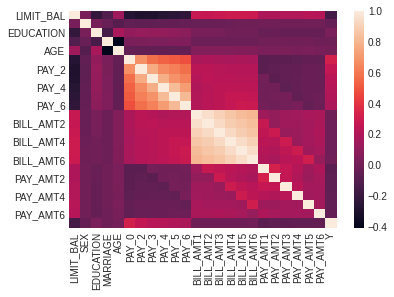

In [70]:
# for col in DF.columns[:24] :
#     con_tab = pd.crosstab(DF[col], DF['Y'])
#     c, p, dof, expected = chi2_contingency(con_tab)
#     if p > 0.05 :
#         print(col, 'и Y',
#               '\nH_0: переменные распределены независимо друг от друга', 
#               '\nP-значение:', np.around(p, 4))
sns.heatmap(DF.corr())

Некоторые признаки связаны с другими идентично. Поэтому в модель имеет смысл включать только некоторые из этих переменных.   

In [72]:

#  из обучающей выборки
DF = DF.drop(['PAY_AMT6', 'PAY_AMT4', 'BILL_AMT2', 'BILL_AMT4', 'PAY_2', 'PAY_4'], axis=1)
#  и из отложенных наблюдений
DF_predict = DF_predict.drop(['PAY_AMT6', 'PAY_AMT4', 'BILL_AMT2', 'BILL_AMT4', 'PAY_2', 'PAY_4'], axis=1)

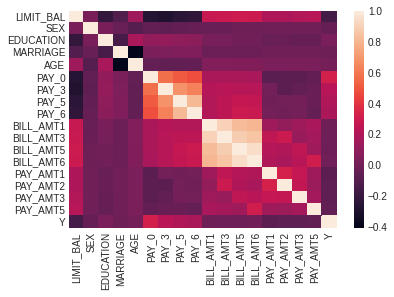

In [73]:
sns.heatmap(DF.corr())

In [74]:

#  из обучающей выборки
DF = DF.drop(['PAY_AMT1', 'PAY_AMT3', 'PAY_AMT5', 'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT5', 'PAY_0', 'PAY_3', 'PAY_5'], axis=1)
#  и из отложенных наблюдений
DF_predict = DF_predict.drop(['PAY_AMT1', 'PAY_AMT3', 'PAY_AMT5', 'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT5', 'PAY_0', 'PAY_3', 'PAY_5'], axis=1)

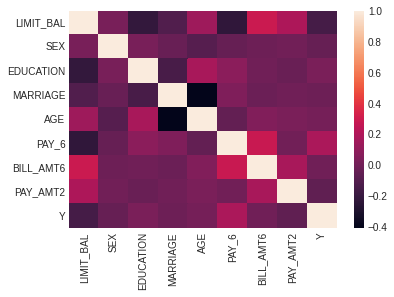

In [75]:
sns.heatmap(DF.corr())

## Перекодировка номинальной и порядковой шкалы   

Теперь перекодируем признаки так, чтобы воспользоваться функцией классификации на дереве решений. Начнём с тех, которые содержат признаки в номинальной шкале (между позициями нет отношения порядка). Перекодируем их в фиктивные с помощью функции `OneHotEncoder()`.   

In [86]:
# имена столбцов с номинальными показателями
nom_col_names = ['SEX']

# создаём объект кодировщика
one_hot = OneHotEncoder()

# кодируем, результат – массив
recoded = one_hot.fit_transform(DF[nom_col_names]).toarray()

# создаём из результата новый фрейм с фиктивными переменными
clmns = one_hot.get_feature_names(nom_col_names)
df_dummy_nom = pd.DataFrame(recoded, columns=clmns)

# выводим размерность итога
print(df_dummy_nom.shape)

# смотрим результат
df_dummy_nom.head()

(25500, 2)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SEX_1  SEX_2
0    0.0    1.0
1    1.0    0.0
2    1.0    0.0
3    0.0    1.0
4    0.0    1.0

In [87]:
# исходник для сравнения
print(DF[nom_col_names].shape)
DF[nom_col_names].head()

(25500, 1)


SEX
23739    2
2303     1
8847     1
6634     2
17316    2

Теперь разбираемся с показателями в порядковой шкале. Для этого воспользуемся `OrdinalEncoder()`. Для начала убедимся, что на этапе исключения пропущенных всё прошло штатно, и значений `'nan'`, которые `OrdinalEncoder()` не умеет обрабатывать, не осталось.  

In [88]:
# имена столбцов с порядковыми показателями
ord_col_names = ['EDUCATION', 'MARRIAGE', 'PAY_6']

# считаем пропуски в столбцах
for col in ord_col_names :
    print('Пропусков в столбце', col, ':',
          sum(DF[col].isnull().astype(int)))

Пропусков в столбце EDUCATION : 0
Пропусков в столбце MARRIAGE : 0
Пропусков в столбце PAY_6 : 0


Всё отлично, пропусков нет, поэтому можно перекодировать все порядковые столбцы в одно действие.   

In [89]:
DF.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    25500.000000  25500.000000  25500.000000  25500.000000  25500.000000   
mean    167239.595294      1.602157      1.855529      1.552078     35.507804   
std     129645.337798      0.489462      0.792227      0.522142      9.211413   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_6      BILL_AMT6      PAY_AMT2             Y  
count  25500.000000   25500.000000  2.550000e+04  25500.000000  
mean      -0.294902   38823.679765  5.943238e+03      0.222392  
std        1.145967   59523.946598  2.181456e+04      0.415861  
min       -2.000000 -339603.000000  0.000000e+00      0.000000  
25%       -1.000000    1243.750000  8.345000e+02      0.000000  
50%        0.000000   17001.500000  2.010000e+03      0.000000  
75%        0.000000   49327.500000  5.000000e+03      0.000000  
max        8.000000  961664.000000  1.227082e+06      1.000000

In [92]:
# создаём списки с порядком кодировки для каждого столбца
enc_education = ['0', '1', '2', '3', '4', '5', '6']
enc_marriage = ['0', '1', '2', '3']
enc_pay_6 = ['-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8']



# перекодировщик
ordinal = OrdinalEncoder(categories=[enc_education, enc_marriage, enc_pay_6])

# кодируем
df_ord = pd.DataFrame(ordinal.fit_transform(DF[ord_col_names]),
                     columns=ord_col_names)

# выводим размерность итога
print(df_ord.shape)

# результат
df_ord.head()

(25500, 3)


EDUCATION  MARRIAGE  PAY_6
0        2.0       2.0    1.0
1        2.0       2.0    2.0
2        1.0       2.0    0.0
3        2.0       2.0    1.0
4        3.0       2.0    2.0

In [93]:
# исходник для сравнения
print(DF[ord_col_names].shape)
DF[ord_col_names].head()

(25500, 3)


EDUCATION  MARRIAGE  PAY_6
23739          2         2     -1
2303           2         2      0
8847           1         2     -2
6634           2         2     -1
17316          3         2      0

Объединим результаты: исходно числовые столбцы, дамми для признаков в номинальной шкале и перекодированные признаки в порядковой шкале – во фрейм под названием `DF_num`.  

In [94]:
# объединяем результаты перекодировки в один фрейм
DF_num = pd.concat([DF.loc[:, DF.dtypes == 'int64'].reset_index(),
                   df_dummy_nom, df_ord], axis=1)

print('Размерность обучающего фрейма после исключения NaN',
      '\nи перекодировки: ', DF_num.shape)

# результат
DF_num.head()

Размерность обучающего фрейма после исключения NaN 
и перекодировки:  (25500, 15)


index  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_6  BILL_AMT6  \
0  23739      80000    2          2         2   51     -1      45966   
1   2303     180000    1          2         2   32      0     134352   
2   8847     200000    1          1         2   33     -2          0   
3   6634      10000    2          2         2   37     -1        390   
4  17316      50000    2          3         2   39      0      18475   

   PAY_AMT2  Y  SEX_1  SEX_2  EDUCATION  MARRIAGE  PAY_6  
0      1500  1    0.0    1.0        2.0       2.0    1.0  
1         0  1    1.0    0.0        2.0       2.0    2.0  
2         0  0    1.0    0.0        1.0       2.0    0.0  
3      1000  0    0.0    1.0        2.0       2.0    1.0  
4      1280  1    0.0    1.0        3.0       2.0    2.0

Повторяем перекодировку для фрейма с отложенными наблюдениями `DF_predict`.   

In [95]:
# перекодировка отложенных наблюдений
#  номинальная шкала -------------------------------------------------------
#   кодируем, результат – массив
recoded = one_hot.fit_transform(DF_predict[nom_col_names]).toarray()

# создаём из результата новый фрейм с фиктивными переменными
clmns = one_hot.get_feature_names(nom_col_names)
df_dummy_nom = pd.DataFrame(recoded, columns=clmns)

#  порядковая шкала --------------------------------------------------------
#   кодируем
df_ord = pd.DataFrame(ordinal.fit_transform(DF_predict[ord_col_names]), 
                        columns = ord_col_names)

#   объединяем результаты
DF_predict_num = pd.concat([DF_predict.loc[:, 
    DF_predict.dtypes == 'int64'].reset_index(), 
                            df_dummy_nom, df_ord], axis=1)

print('Размерность фрейма с отложенными наблюдениями после исключения NaN',
      '\nи перекодировки: ', DF_predict_num.shape)

# результат
DF_predict_num.head()

Размерность фрейма с отложенными наблюдениями после исключения NaN 
и перекодировки:  (4500, 15)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


index  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_6  BILL_AMT6  \
0      6     500000    1          1         2   29      0     473944   
1     12     630000    2          2         2   41     -1       2870   
2     14     250000    1          1         2   29      0      55512   
3     17     320000    1          1         1   49     -1     195599   
4     42      10000    1          2         2   22      0       4451   

   PAY_AMT2  Y  SEX_1  SEX_2  EDUCATION  MARRIAGE  PAY_6  
0     40000  0    1.0    0.0        1.0       2.0    2.0  
1      6500  0    0.0    1.0        2.0       2.0    1.0  
2      3000  0    1.0    0.0        1.0       2.0    2.0  
3     10000  0    1.0    0.0        1.0       1.0    1.0  
4      2927  0    1.0    0.0        2.0       2.0    2.0

# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [96]:
# выращиваем дерево на всех объясняющих
X = DF_num.drop(['index', 'Y'], axis=1)
y = DF_num['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

5971

In [97]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

50

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [98]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.693


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [99]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 2131
Энтропия листьев для первых 5 значений alpha: [0.01060713 0.01060713 0.01060713 0.01060713 0.01060713]


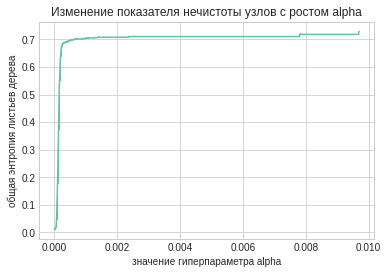

In [100]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [101]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 419.59 секунд


In [102]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 22.57 секунд


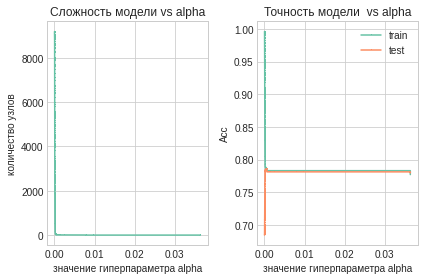

In [104]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [105]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 25 
соответствующая Acc на тестовой: 0.786 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.684


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [106]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

4470

In [107]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

42

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [108]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[17,
 17,
 17,
 17,
 17,
 17,
 15,
 15,
 15,
 15,
 11,
 11,
 11,
 11,
 11,
 9,
 9,
 7,
 7,
 7,
 3,
 3,
 1]

In [109]:
# plot_tree?

Количество узлов: 17 
Точность дерева на тестовой: 0.786


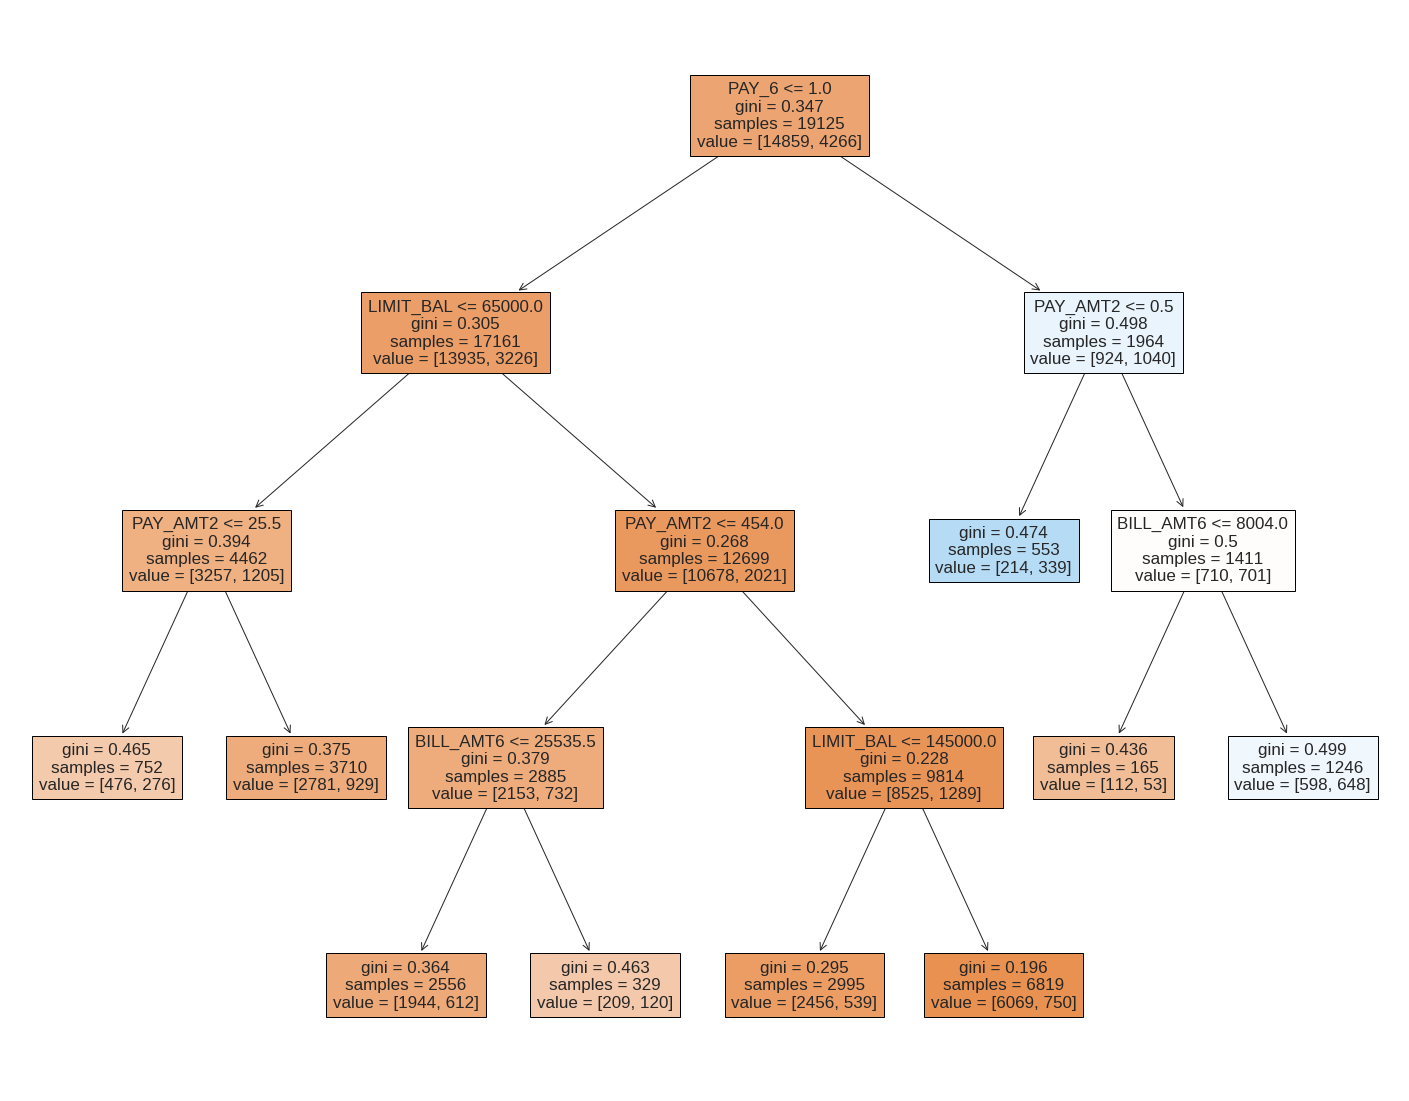

In [111]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 17
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [112]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- PAY_6 <= 1.00
|   |--- LIMIT_BAL <= 65000.00
|   |   |--- PAY_AMT2 <= 25.50
|   |   |   |--- class: 0
|   |   |--- PAY_AMT2 >  25.50
|   |   |   |--- class: 0
|   |--- LIMIT_BAL >  65000.00
|   |   |--- PAY_AMT2 <= 454.00
|   |   |   |--- BILL_AMT6 <= 25535.50
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT6 >  25535.50
|   |   |   |   |--- class: 0
|   |   |--- PAY_AMT2 >  454.00
|   |   |   |--- LIMIT_BAL <= 145000.00
|   |   |   |   |--- class: 0
|   |   |   |--- LIMIT_BAL >  145000.00
|   |   |   |   |--- class: 0
|--- PAY_6 >  1.00
|   |--- PAY_AMT2 <= 0.50
|   |   |--- class: 1
|   |--- PAY_AMT2 >  0.50
|   |   |--- BILL_AMT6 <= 8004.00
|   |   |   |--- class: 0
|   |   |--- BILL_AMT6 >  8004.00
|   |   |   |--- class: 1



---

# Бэггинг  

Модель бэггинга использует бутстреп, чтобы вырастить $B$ деревьев на выборках с повторами из обучающих данных. Построим модель для $B=50$ деревьев.  

In [113]:
# параметр B: количество деревьев
num_trees = 50

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
# модель с бэггингом
tree_bag = BaggingClassifier(base_estimator=cls_one_tree,
                             n_estimators=num_trees,
                             random_state=my_seed)

cv = cross_val_score(tree_bag, X, y, cv=kfold)

# таймер
toc = time.perf_counter()
print(f"Обучение модели с бэггингом на {num_trees:0.0f} деревьях", 
      " и перекрёстной проверкой ", 
      f"заняло {toc - tic:0.2f} секунд", sep='')

Обучение модели с бэггингом на 50 деревьях и перекрёстной проверкой заняло 34.15 секунд


In [114]:
# точность
np.around(np.mean(cv), 3)

0.77

Итак, мы построили модель, выбрав параметр $B$ случайным образом. Воспользуемся функцией `GridSearchCV()`, чтобы перебрать 5 вариантов значений для параметра $B$.  

In [115]:
# настроим параметры бэггинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                  param_grid, scoring='accuracy', cv=kfold)

tree_bag = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 77.10 секунд


In [116]:
# точность лучшей модели
np.around(tree_bag.best_score_, 3)

0.769

In [117]:
# количество деревьев у лучшей модели
tree_bag.best_params_

{'n_estimators': 40}

In [118]:
tree_bag.best_estimator_.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Таким образом, перебрав несколько вариантов для $B$, мы немного улучшили первоначальную точность модели бэггинга.  

In [119]:
# записываем точность
score.append(np.around(tree_bag.best_score_, 3))
score_models.append('bagging_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели bagging_GS : 0.769



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [120]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

Модель    Acc
0     one_tree  0.693
1  pruned_tree  0.684
2   bagging_GS  0.769

Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель бэггинга. Сделаем прогноз на отложенные наблюдения.   

In [122]:
# данные для прогноза
X_pred = DF_predict_num.drop(['index', 'Y'], axis=1)
# строим прогноз
y_hat = tree_bag.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3535
           1       0.44      0.23      0.30       965

    accuracy                           0.77      4500
   macro avg       0.63      0.57      0.58      4500
weighted avg       0.73      0.77      0.74      4500



Сравним точность на отложенных наблюдениях с точностью моделей из упражнения 4. 

| | precision | recall | f1-score | support |
| :---: |     :---:      | :---: | :---: | :---: |
| 0 | 0.82 | 0.97 | 0.89 | 3535 |
| 1 | 0.70 | 0.24 | 0.36 | 965 |
| accuracy | | | 0.82 | 4500 |
| macro avg|  0.76  | 0.61  | 0.62  | 4500 |
| weighted avg | 0.80 | 0.82 | 0.78 | 4500 |


| | Модель | Acc |
| :---: |     :---:      ||
| 0 | logit_PLS	 |  0.796 ||
| 1 | logit_lasso | 0.810 | |


Точность моделей из упражнения 4(то есть из прошлой лабы) оказалась лучше.